### Name: Sultan Bamukhaier


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import time
from collections import OrderedDict
import math
import copy
from PIL import Image
import argparse
import matplotlib.image as mpimg
import json
from argparse import ArgumentParser

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets


data_transforms = {'train_transforms':transforms.Compose([transforms.RandomRotation(30),
                                                          transforms.RandomResizedCrop(224),
                                                          transforms.RandomHorizontalFlip(),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                                               [0.229, 0.224, 0.225])]) ,
            
                   
                   'valid_transforms':transforms.Compose([transforms.Resize(256),
                                                          transforms.CenterCrop(224),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                                               [0.229, 0.224, 0.225])]) ,
                    
                   
                   'test_transforms': transforms.Compose([transforms.Resize(256),
                                                          transforms.CenterCrop(224),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                                               [0.229, 0.224, 0.225])]) }



# TODO: Load the datasets with ImageFolder


image_datasets = { 'train_data': datasets.ImageFolder(train_dir , transform = data_transforms['train_transforms']) ,
                   'valid_data': datasets.ImageFolder(valid_dir , transform = data_transforms['valid_transforms']) ,
                   'test_data' : datasets.ImageFolder(test_dir  , transform = data_transforms['test_transforms' ]) }



# TODO: Using the image datasets and the trainforms, define the dataloaders


train_batch_size=32
valid_batch_size=32
test_batch_size=32

dataloaders = {'trainloader': torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=train_batch_size, shuffle=True),
               'validloader': torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size= valid_batch_size)      ,
               'testloader' : torch.utils.data.DataLoader(image_datasets['test_data'] , batch_size= test_batch_size )      }

In [4]:
# data_transforms:
train_transforms = data_transforms['train_transforms']
valid_transforms = data_transforms['valid_transforms']
test_transforms  = data_transforms['test_transforms']

# image_datasets:
train_data = image_datasets['train_data']
valid_data = image_datasets['valid_data']
test_data  = image_datasets['test_data']

# dataloaders
trainloader = dataloaders['trainloader']
validloader = dataloaders['validloader']
testloader  = dataloaders['testloader']

In [5]:
print('len_train_len',len(train_data))
print('valid_train_len',len(valid_data))
print('test_train_len',len(test_data))
print('classes',train_data.classes)

len_train_len 6552
valid_train_len 818
test_train_len 819
classes ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


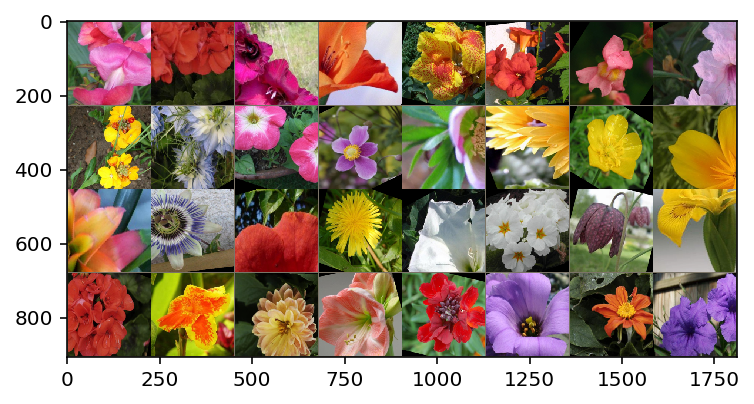

In [6]:
#Viewing a batch of TrainLoader Images:

def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
inputs, classes = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
print('category label to category name:',cat_to_name)

category label to category name: {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'har

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [9]:
# TODO: Build and train your network

#Select an architecture:
arch = 'vgg19'
#Loading the pre-trained module for the selected architecture:
if arch == 'vgg16':
    model = models.vgg16(pretrained=True)
elif arch == 'vgg19':
    model = models.vgg19(pretrained=True)
elif arch == 'alexnet':
    model = models.alexnet(pretrained=True)
#Raising an error if the selected architecture wasn't one of the above:
else:
    raise ValueError('Unexpected network architecture', arch ,
                     'please select arch : vgg16 or vgg19 or alexnet')
    
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [10]:
#Initializing the input to my classifier depending on the chosen mode:
if arch == 'vgg19' or arch == 'vgg16':
    in_features = 25088 
elif arch == 'alexnet':
    in_features = 9216
#Entering the hidden layers of my classifier (Chosed to be two integers entered as a list)
hidden_layers = [4096,1000]
#The output of my classifier (number of classes)
out_features = len(train_data.classes)
#To select the dropout values:
drop_out = 0.2

print('in_features',in_features,'\nhidden_layers',hidden_layers[0],'x',hidden_layers[1],'\nout_features',out_features)

in_features 25088 
hidden_layers 4096 x 1000 
out_features 102


In [11]:
#Builing my neural network:
def load_model(in_features=25088,hidden_layers=[4096,1000],out_features=102,drop_out=0.2):
#Freezing the loaded model parameters:
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(in_features, hidden_layers[0])),
                              ('relu1', nn.ReLU()),

                              ('drop1', nn.Dropout(p=drop_out)),

                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),

                              ('drop1', nn.Dropout(p=drop_out)),
    
                              ('fc3', nn.Linear(hidden_layers[1], out_features)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    
    return classifier

In [12]:
#Loading my classifer:
classifier = load_model(in_features,hidden_layers,out_features,drop_out)

In [13]:
#Saving the loaded classifier to my model:
model.classifier = classifier

print(model.classifier)

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [14]:
#Selecting the criterion type:
criterion = nn.NLLLoss()
#Selecting the optimizer type:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

#Using cuda if available. Otherwise: using cpu
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    print('please activate the GPU for faster running')
    
#Assigning the number of epochs:
epochs = 10
#Assigning the number of loaders entering the training function (Loading & Validating):
loader_types= [trainloader , validloader]

print('criterion:',criterion,'\ndevice:',device,'\nnumber of epochs:',epochs,'\n\noptimizer:',optimizer)

criterion: NLLLoss() 
device: cuda 
number of epochs: 10 

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


In [15]:
#My training function:

def do_deep_learning(model, loader_types=[trainloader,validloader], epochs=3, criterion=nn.NLLLoss(), optimizer=optim.Adam(model.classifier.parameters(), lr=0.0005), device='cuda'):

    
#Sending model to device used (CPU or Cuda):

    model.to(device)

#Will be used to copy the weight of the hiest accuracy:

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
#Setting the starting time, will be used later to calculate the running time:

    start = time.time()

    
#Starting the training loops:

    for e in range(epochs):
    

#Will use the loader_types selected (trainloader for training & validloader for validating)

        for loader_type in loader_types:
    

    
#Initializing for the training mode:
            if loader_type == trainloader:
        
                model.train()        
                train_running_loss = 0
                steps = 0
        
        
#Initializing for the validating mode:

            elif loader_type == validloader:
        
                model.eval()
                valid_running_loss = 0
                correct = 0
                total = 0
                steps = 0

#Extracting the inputs & labels from images in trainloader & validloader, quantities depend on number of batches:
            for inputs, labels in loader_type:
            
#Increment the step for counting:
                steps += 1
#Sending inputs & labels to the device (Usually cuda)
                inputs, labels = inputs.to(device), labels.to(device)
#Erasing the gradient datas:    
                optimizer.zero_grad()
#forward step:            
                outputs = model.forward(inputs)
#Using criterion to calculate the loss:           
                loss = criterion(outputs, labels)
#Only in training mode, Do training & update the weights:
                if loader_type == trainloader:
                    loss.backward()
                    optimizer.step() 
                    train_running_loss += loss.item()

#When the training mode number of batches are completed:
                    if steps % (math.ceil(len(train_data)/train_batch_size)) == 0:
#Printing the training epoch result:
                        print("Training Loss in Epoch: {}/{} = {:.4f} ".format(e+1, epochs,
                                                        train_running_loss/len(train_data)*train_batch_size))    
               

#Only in evaluation mode, do the following:
                elif loader_type == validloader:
#Summing the losses and save them in valid_running_loss:
                    valid_running_loss += loss.item()
            
#After the forward move, do predicting to each input, find the maximum prediction value, if matches the labels save as 1, otherwise save as 0:
                    _, predicted = torch.max(outputs.data, 1)
#Adding the number of inputs in the current batch to the variable total:
                    total += labels.size(0)
#Summing the total number of correct prediction in the given batch:
                    correct += (predicted == labels).sum().item()
        
#When the validating mode number of batches are completed:
                    if steps % (math.ceil(len(valid_data)/valid_batch_size)) == 0:
#Printing the validating epoch result:               
                        print("Validation Loss in Epoch: {}/{} = {:.4f} ".format(e+1, epochs,
                                                        valid_running_loss/len(valid_data)*valid_batch_size))                                                      
                        
#Calculate the percentage of the correct prediction in the epoch:
        epoch_acc = (100 * correct / total) 
        print("Accuracy of the network on the {%d} valid images: %d %% "%(len(valid_data) , epoch_acc))
        
#Checking if the last model has the best weights, if yes, save in best_model_wts:
        if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
#Printing the total running time:      
    print(f"DEVICE = {device}; Total Time: {(time.time() - start):.3f} seconds")
#Printing the best accuracy:
    print("The Best Accuracy Was: %d %%" %best_acc) 
    
#Loading the best model weights:
    model.load_state_dict(best_model_wts)

    
    return model

In [16]:
do_deep_learning(model, loader_types, epochs, criterion, optimizer, device)

Training Loss in Epoch: 1/10 = 2.4567 
Validation Loss in Epoch: 1/10 = 0.9764 
Accuracy of the network on the {818} valid images: 72 % 
Training Loss in Epoch: 2/10 = 1.2258 
Validation Loss in Epoch: 2/10 = 0.6727 
Accuracy of the network on the {818} valid images: 81 % 
Training Loss in Epoch: 3/10 = 0.9640 
Validation Loss in Epoch: 3/10 = 0.6376 
Accuracy of the network on the {818} valid images: 82 % 
Training Loss in Epoch: 4/10 = 0.8470 
Validation Loss in Epoch: 4/10 = 0.4951 
Accuracy of the network on the {818} valid images: 85 % 
Training Loss in Epoch: 5/10 = 0.7434 
Validation Loss in Epoch: 5/10 = 0.4530 
Accuracy of the network on the {818} valid images: 86 % 
Training Loss in Epoch: 6/10 = 0.7233 
Validation Loss in Epoch: 6/10 = 0.5086 
Accuracy of the network on the {818} valid images: 87 % 
Training Loss in Epoch: 7/10 = 0.6845 
Validation Loss in Epoch: 7/10 = 0.4239 
Accuracy of the network on the {818} valid images: 87 % 
Training Loss in Epoch: 8/10 = 0.6089 
Va

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set

#Checking the module accuracy using the testing images:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the {} test images: %d %%'.format(len(test_data)) % (100 * correct / total))
    

In [18]:
check_accuracy_on_test(testloader)

Accuracy of the network on the 819 test images: 86 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
#Mapping the classes with indices:
model.class_to_idx = train_data.class_to_idx

print(model.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [20]:
#TODO: Save the checkpoint 

#Creating a dictionary of the checkpoints:
checkpoint = { 'state_dict' : model.state_dict(),
               'class_to_idx' : model.class_to_idx,
               'optimizer' : optimizer, 
               'arch' : arch,
               'hidden_layers' : hidden_layers,   
               'in_features' : in_features, 
               'out_features' : out_features, 
               'criterion' : criterion,
               'epochs' : epochs,
               'loader_types' : loader_types,
               'classifier' : classifier}

#Saving my dictionary the checkpoint_path:
torch.save(checkpoint , 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
#Loading the saved checkpoints from checkpoint_path:

checkpoint = torch.load('checkpoint.pth')

#Extrcting the saved model weights:
state_dict = checkpoint['state_dict']

model.class_to_idx = checkpoint['class_to_idx'] 

optimizer = checkpoint['optimizer']
      
arch = checkpoint['arch']
    
hidden_layers = checkpoint['hidden_layers']   
    
in_features = checkpoint['in_features']   
        
out_features = checkpoint['out_features']   
            
criterion = checkpoint['criterion']
    
epochs = checkpoint['epochs']
    
loader_types = checkpoint['loader_types']

classifier = checkpoint['classifier']
        
model.classifier = classifier

#Loading the saved weights to my model:
model.load_state_dict(state_dict)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [22]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
#Loading the image:
    pil_image = Image.open(image)

#Defining the image_transforms: Resizing, CenterCropping, Then converting to Tensor:
    image_transform=transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        ])
    
#Applying the image_transforms, output type is Tensor:    
    pil_image = image_transform(pil_image).float()

#Converting the image from Tensor to Numpy:
    np_image = np.array(pil_image)    
    

#subtract the means from each color channel, then divide by the standard deviation:    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std 
    
#PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
#reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions

#Reordering the dimension, it will start with the third dimension (Color Chanel). Then first & second:
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [23]:
#To reverse the work process_image function to check my work:

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

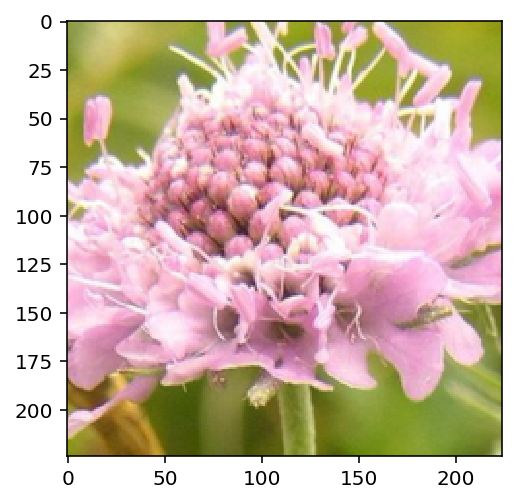

In [24]:
%matplotlib inline

#Plotting an image after passing it to both functions (process_image & imshow):
_= imshow(process_image(test_dir + '/22/image_05362.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [25]:
# TODO: Display an image along with the top 5 classes

In [26]:
def predict(image_path, model, topk=5):
    
#To pre-process the input image, image will be resized, center cropped, normalized & converted to numpy:
    image = process_image(image_path)

#Converting the input from numpy to tensor
    image_tensor = torch.from_numpy(image)
    
#Converting the tensor type to torch.FloatTensor
    image_tensor = image_tensor.type(torch.FloatTensor)

    
    model_input = image_tensor.unsqueeze(0)
    
#Sending the input to cuda
    model_input = model_input.to('cuda')

#Evaluation mode:
    model.eval()
    
#Forward step in my model:
    probs = torch.exp(model.forward(model_input))

#Saving the top (topk=5) predictions in top_probs & The indicies for the top (topk=5) predictions in top_idicies:
    top_probs,top_idicies = probs.topk(topk)
    
#Convering the results from tensor to Lists:
    top_probs = top_probs.tolist()[0]
    top_idicies = top_idicies.tolist()[0]
    
#Making a dict such as:{idicies:labels}
    idx_to_class = dict(zip(model.class_to_idx.values(),model.class_to_idx.keys()))
    
#Making a list matching the indices in top_indices with the actual labels (folder names):    
    top_labels = [idx_to_class[idx] for idx in top_idicies]
    
#Mapping labels with flower names:
    top_flowers = [cat_to_name[lable] for lable in top_labels]

    

    return top_probs,top_flowers


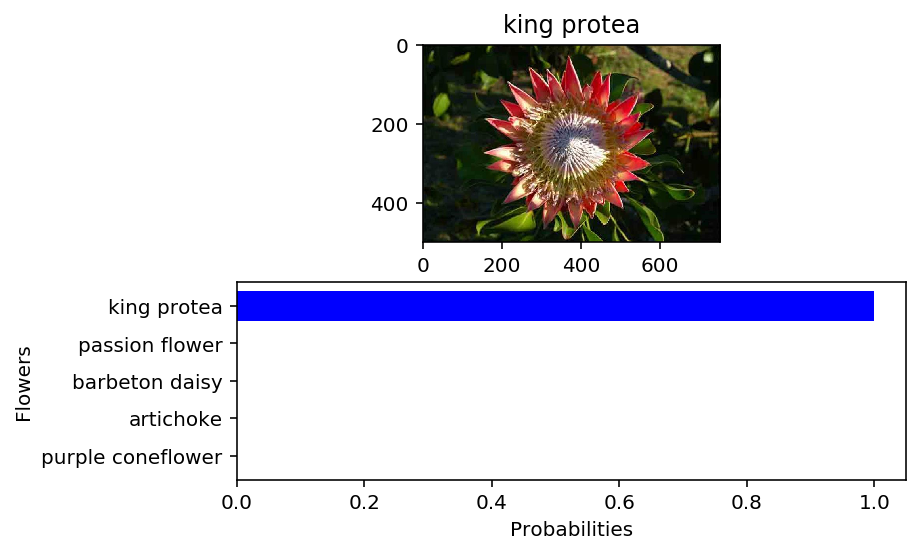

In [27]:
#Test:1 

#Loading image from flowers testing folder:
image = mpimg.imread('flowers/test/13/image_05745.jpg')
#Arrange to be 2 cloumns 1 row:
f, axarr = plt.subplots(2,1)
#Showing the image using imshow function
axarr[0].imshow(image)
#Adding title
axarr[0].set_title('king protea')
#Predicting the image:
probs, classes = predict('flowers/test/13/image_05745.jpg', model, topk=5)
#Number of classes:
y_pos = np.arange(len(classes))
#Plotting:
axarr[1].barh(y_pos, probs, align='center', color='blue')
axarr[1].set_yticks(y_pos)
axarr[1].set_yticklabels(classes)
axarr[1].invert_yaxis() 
_ = axarr[1].set_xlabel('Probabilities')
_ = axarr[1].set_ylabel('Flowers')

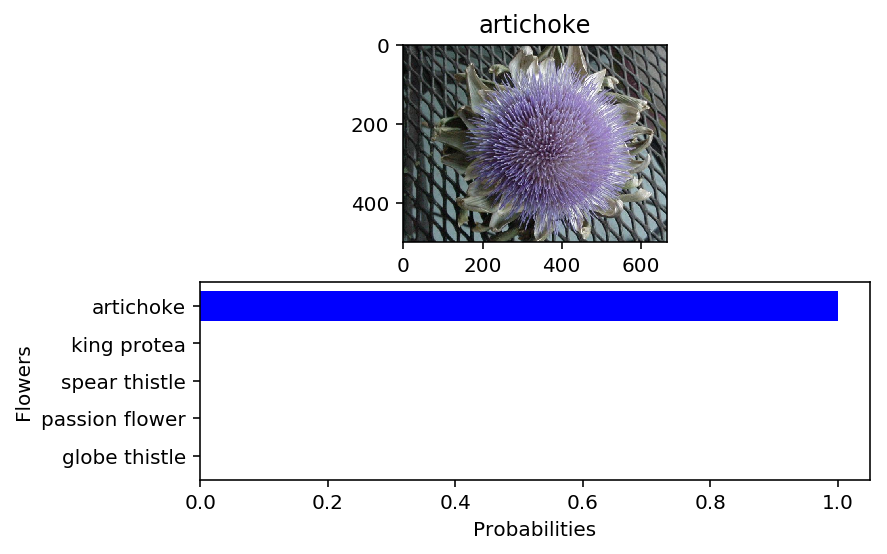

In [28]:
#Test:2

#Loading image from flowers testing folder:
image = mpimg.imread('flowers/test/29/image_04145.jpg')
#Arrange to be 2 cloumns 1 row:
f, axarr = plt.subplots(2,1)
#Showing the image using imshow function
axarr[0].imshow(image)
#Adding title
axarr[0].set_title('artichoke')
#Predicting the image:
probs, classes = predict('flowers/test/29/image_04145.jpg', model, topk=5)
#Number of classes:
y_pos = np.arange(len(classes))
#Plotting:
axarr[1].barh(y_pos, probs, align='center', color='blue')
axarr[1].set_yticks(y_pos)
axarr[1].set_yticklabels(classes)
axarr[1].invert_yaxis() 
_ = axarr[1].set_xlabel('Probabilities')
_ = axarr[1].set_ylabel('Flowers')

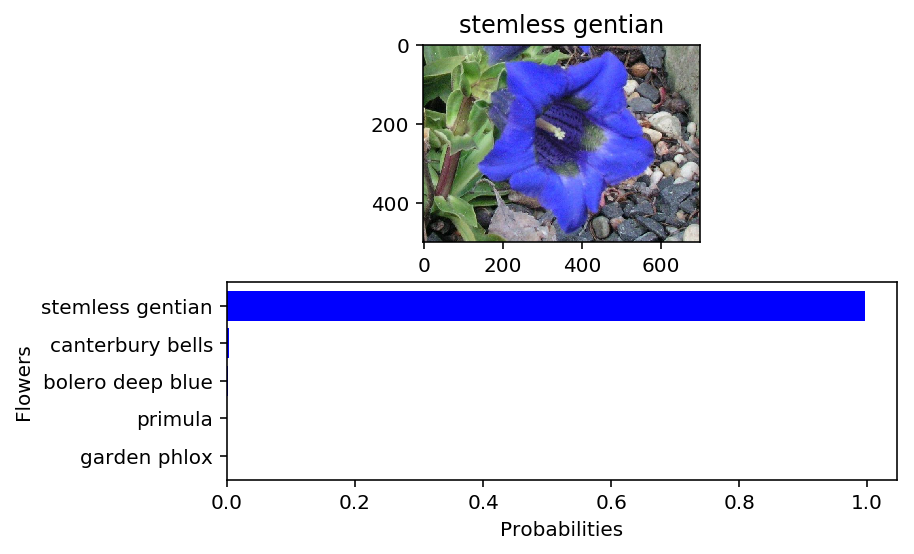

In [29]:
#Test:3

#Loading image from flowers testing folder:
image = mpimg.imread('flowers/test/28/image_05270.jpg')
#Arrange to be 2 cloumns 1 row:
f, axarr = plt.subplots(2,1)
#Showing the image using imshow function
axarr[0].imshow(image)
#Adding title
axarr[0].set_title('stemless gentian')
#Predicting the image:
probs, classes = predict('flowers/test/28/image_05270.jpg', model, topk=5)
#Number of classes:
y_pos = np.arange(len(classes))
#Plotting:
axarr[1].barh(y_pos, probs, align='center', color='blue')
axarr[1].set_yticks(y_pos)
axarr[1].set_yticklabels(classes)
axarr[1].invert_yaxis() 
_ = axarr[1].set_xlabel('Probabilities')
_ = axarr[1].set_ylabel('Flowers')